## 1. Загрузка данных 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import random

# Добавляем функцию set_seed
def set_seed(seed: int = 42) -> None:
    """
    Фиксируем все генераторы случайных чисел для воспроизводимости
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Устанавливаем начальный seed
set_seed(42)

# Загрузка данных
df = pd.read_csv('air_quality.csv')

# Подготовка данных
X = df.drop('air_quality', axis=1)
y = df['air_quality']

D:\setup\anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 2. Подготовьте данные к обучению - 1 балл

- Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией. В качестве целевой переменной используйте столбец air_quality - бинарный столбец (0 - плохое качество воздуха, 1 - хорошее качество воздуха).

- Создайте объекты для работы с данными в PyTorch - Dataset и DataLoader для обучающей, валидационной и тестовой выборок. Выберите оптимальный, на ваш взгляд, batch_size.

In [2]:
# Устанавливаем seed перед разделением данных
set_seed(42)

# Разделяем данные
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

In [3]:
# Создаем класс для работы с данными
class AirQualityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.LongTensor(y.values)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Создаем объекты Dataset
train_dataset = AirQualityDataset(X_train, y_train)
val_dataset = AirQualityDataset(X_val, y_val)
test_dataset = AirQualityDataset(X_test, y_test)

# Создаем объекты DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 3. Реализуйте класс нейросетевой модели для решения задачи - 1 балл

- Минимальное количество Linear слоев в структуре - 3 штуки: входной слой, скрытый слой, выходной классификационный слой.
- Подберите оптимальные для задачи функции активации - ReLU, Sigmoid, Tanh, LeakyReLU...
- Реализуйте логику прохождения данных по сети в методе forward
- Cоздайте объект модели, реализуйте перевод модели на gpu

Примечание: в качестве устрйо ства я указал свой девайс cuda:0. девайс может отличатсья взависимости от конфигурации вашего ПК

In [5]:
import torch.nn as nn

# Устанавливаем seed для инициализации весов
set_seed(42)

class AirQualityNet(nn.Module):
    def __init__(self, input_size):
        super(AirQualityNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x.squeeze()

# Получаем размерность входного слоя из данных
input_size = X_train.shape[1]

# Создаем объект модели
model = AirQualityNet(input_size)

# Проверяем доступность GPU и переносим модель на него
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## 4. Напишите код цикла обучения - train-loop и валидации - eval-loop. В процессе обучения сохраняйте значения функции потерь на тренировочной и валидационной выборках - 1 балл

Epoch 1/30: 100%|██████████████████████████████████████████████████████████████████████| 94/94 [00:03<00:00, 23.55it/s]


Epoch [1/30]
Training Loss: 0.4020
Validation Loss: 0.3009
--------------------------------------------------


Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 232.10it/s]


Epoch [2/30]
Training Loss: 0.2678
Validation Loss: 0.2129
--------------------------------------------------


Epoch 3/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 229.83it/s]


Epoch [3/30]
Training Loss: 0.2096
Validation Loss: 0.1815
--------------------------------------------------


Epoch 4/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 229.27it/s]


Epoch [4/30]
Training Loss: 0.1902
Validation Loss: 0.1815
--------------------------------------------------


Epoch 5/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 248.02it/s]


Epoch [5/30]
Training Loss: 0.1818
Validation Loss: 0.1398
--------------------------------------------------


Epoch 6/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 246.07it/s]


Epoch [6/30]
Training Loss: 0.1912
Validation Loss: 0.1561
--------------------------------------------------


Epoch 7/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 258.95it/s]


Epoch [7/30]
Training Loss: 0.1635
Validation Loss: 0.1415
--------------------------------------------------


Epoch 8/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 251.34it/s]


Epoch [8/30]
Training Loss: 0.1742
Validation Loss: 0.1897
--------------------------------------------------


Epoch 9/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 242.89it/s]


Epoch [9/30]
Training Loss: 0.1626
Validation Loss: 0.1300
--------------------------------------------------


Epoch 10/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 249.34it/s]


Epoch [10/30]
Training Loss: 0.1694
Validation Loss: 0.1333
--------------------------------------------------


Epoch 11/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 237.37it/s]


Epoch [11/30]
Training Loss: 0.1570
Validation Loss: 0.1256
--------------------------------------------------


Epoch 12/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 229.83it/s]


Epoch [12/30]
Training Loss: 0.1474
Validation Loss: 0.1202
--------------------------------------------------


Epoch 13/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 241.64it/s]


Epoch [13/30]
Training Loss: 0.1542
Validation Loss: 0.1146
--------------------------------------------------


Epoch 14/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 245.43it/s]


Epoch [14/30]
Training Loss: 0.1469
Validation Loss: 0.1113
--------------------------------------------------


Epoch 15/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 250.67it/s]


Epoch [15/30]
Training Loss: 0.1535
Validation Loss: 0.1240
--------------------------------------------------


Epoch 16/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 250.67it/s]


Epoch [16/30]
Training Loss: 0.1577
Validation Loss: 0.1694
--------------------------------------------------


Epoch 17/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 220.66it/s]


Epoch [17/30]
Training Loss: 0.1441
Validation Loss: 0.1075
--------------------------------------------------


Epoch 18/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 255.44it/s]


Epoch [18/30]
Training Loss: 0.1382
Validation Loss: 0.1711
--------------------------------------------------


Epoch 19/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 257.54it/s]


Epoch [19/30]
Training Loss: 0.1440
Validation Loss: 0.1036
--------------------------------------------------


Epoch 20/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 256.40it/s]


Epoch [20/30]
Training Loss: 0.1450
Validation Loss: 0.1747
--------------------------------------------------


Epoch 21/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 257.54it/s]


Epoch [21/30]
Training Loss: 0.1336
Validation Loss: 0.1128
--------------------------------------------------


Epoch 22/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 261.11it/s]


Epoch [22/30]
Training Loss: 0.1368
Validation Loss: 0.1133
--------------------------------------------------


Epoch 23/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 257.54it/s]


Epoch [23/30]
Training Loss: 0.1508
Validation Loss: 0.1232
--------------------------------------------------


Epoch 24/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 236.78it/s]


Epoch [24/30]
Training Loss: 0.1291
Validation Loss: 0.0953
--------------------------------------------------


Epoch 25/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 256.83it/s]


Epoch [25/30]
Training Loss: 0.1380
Validation Loss: 0.1200
--------------------------------------------------


Epoch 26/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 256.14it/s]


Epoch [26/30]
Training Loss: 0.1297
Validation Loss: 0.0939
--------------------------------------------------


Epoch 27/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 258.96it/s]


Epoch [27/30]
Training Loss: 0.1268
Validation Loss: 0.1366
--------------------------------------------------


Epoch 28/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 254.74it/s]


Epoch [28/30]
Training Loss: 0.1346
Validation Loss: 0.1435
--------------------------------------------------


Epoch 29/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 261.84it/s]


Epoch [29/30]
Training Loss: 0.1402
Validation Loss: 0.0929
--------------------------------------------------


Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 257.53it/s]


Epoch [30/30]
Training Loss: 0.1255
Validation Loss: 0.0889
--------------------------------------------------


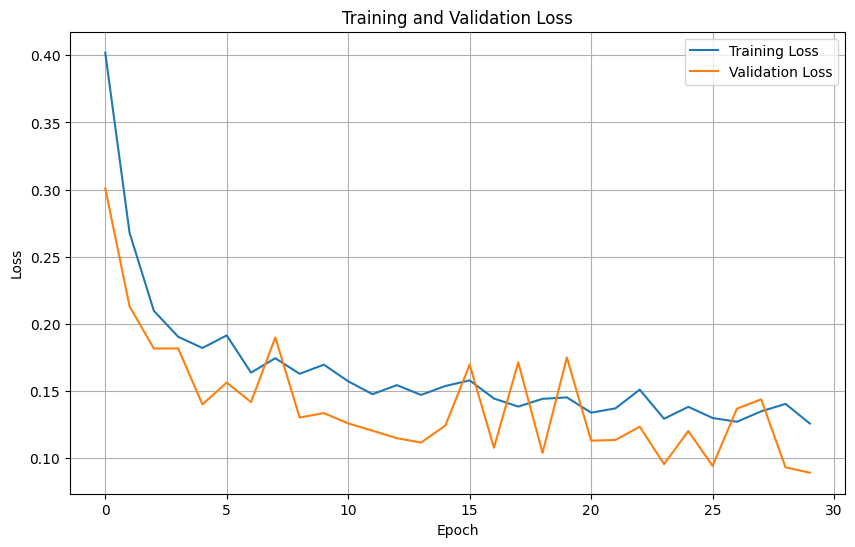


Отчет о классификации:
                  precision    recall  f1-score   support

 Плохое качество       0.95      0.95      0.95       300
Хорошее качество       0.98      0.98      0.98       700

        accuracy                           0.97      1000
       macro avg       0.97      0.97      0.97      1000
    weighted avg       0.97      0.97      0.97      1000



In [6]:
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    # Устанавливаем seed перед началом обучения
    set_seed(42)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print('-' * 50)
    
    return train_losses, val_losses

# Настройка обучения
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

# Запуск обучения
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

# Визуализация результатов обучения
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Оцениваем модель на тестовой выборке
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float().cpu().numpy()
        y_pred.extend(predicted)
        y_true.extend(labels.numpy())

# Выводим отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_true, y_pred, target_names=['Плохое качество', 'Хорошее качество']))

# Сохраняем обученную модель
torch.save(model.state_dict(), 'air_quality_model.pth')

## 5. Обучите модель и проверьте ее качество - 1 балл

- Выберите оптимизатор, в качестве функции потерь используйте nn.BCELoss
- Запустите обучение, постарайтесь подобрать оптимальные скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val
- Измерьте качество лучшей модели на тестовой выборке, постройте отчет о классификации - classification_report


Обучение с learning rate: 0.001


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 244.80it/s]


Epoch [5/50]
Train Loss: 0.1693, Val Loss: 0.1485


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 248.68it/s]


Epoch [10/50]
Train Loss: 0.1648, Val Loss: 0.1297


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 251.33it/s]


Epoch [15/50]
Train Loss: 0.1422, Val Loss: 0.1109


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 263.29it/s]


Epoch [20/50]
Train Loss: 0.1483, Val Loss: 0.1220


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 261.85it/s]


Epoch [25/50]
Train Loss: 0.1359, Val Loss: 0.0994


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 254.72it/s]


Epoch [30/50]
Train Loss: 0.1201, Val Loss: 0.1250


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 254.48it/s]


Epoch [35/50]
Train Loss: 0.1298, Val Loss: 0.0862


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 258.93it/s]


Epoch [40/50]
Train Loss: 0.1149, Val Loss: 0.0954


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 256.86it/s]


Epoch [45/50]
Train Loss: 0.1141, Val Loss: 0.0803


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 256.85it/s]


Epoch [50/50]
Train Loss: 0.1163, Val Loss: 0.1115

Обучение с learning rate: 0.0001


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 260.36it/s]


Epoch [5/50]
Train Loss: 0.3973, Val Loss: 0.3799


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 258.25it/s]


Epoch [10/50]
Train Loss: 0.3052, Val Loss: 0.2847


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 232.65it/s]


Epoch [15/50]
Train Loss: 0.2454, Val Loss: 0.2240


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 227.05it/s]


Epoch [20/50]
Train Loss: 0.2268, Val Loss: 0.1933


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 239.79it/s]


Epoch [25/50]
Train Loss: 0.2044, Val Loss: 0.1743


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 237.97it/s]


Epoch [30/50]
Train Loss: 0.1901, Val Loss: 0.1678


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 241.05it/s]


Epoch [35/50]
Train Loss: 0.1898, Val Loss: 0.1507


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 242.90it/s]


Epoch [40/50]
Train Loss: 0.1801, Val Loss: 0.1482


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 238.57it/s]


Epoch [45/50]
Train Loss: 0.1768, Val Loss: 0.1430


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 237.98it/s]


Epoch [50/50]
Train Loss: 0.1765, Val Loss: 0.1391


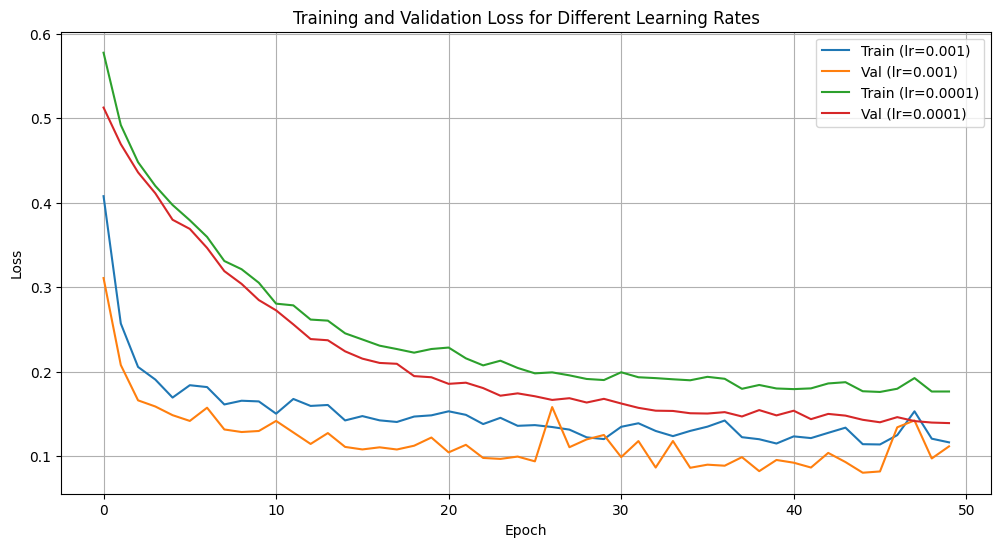


Лучший learning rate: 0.001

Отчет о классификации:
                  precision    recall  f1-score   support

 Плохое качество       0.88      0.99      0.93       300
Хорошее качество       0.99      0.94      0.97       700

        accuracy                           0.96      1000
       macro avg       0.94      0.96      0.95      1000
    weighted avg       0.96      0.96      0.96      1000



In [7]:
from sklearn.metrics import classification_report
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# Функция для оценки модели на тестовой выборке
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float().cpu().numpy()
            all_predictions.extend(predicted)
            all_labels.extend(labels.numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Устанавливаем seed перед обучением
set_seed(42)

# Параметры обучения
learning_rates = [0.001, 0.0001]  # Попробуем разные learning rates
num_epochs = 50
best_val_loss = float('inf')
best_model_state = None

# Словарь для хранения результатов для разных learning rates
results = {}

for lr in learning_rates:
    print(f"\nОбучение с learning rate: {lr}")
    
    # Устанавливаем seed перед инициализацией модели для каждого lr
    set_seed(42)
    
    # Инициализируем модель и оптимизатор
    model = AirQualityNet(input_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    # Списки для хранения потерь
    train_losses = []
    val_losses = []
    
    # Обучение модели
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Сохраняем лучшую модель
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    results[lr] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }

# Визуализация результатов для разных learning rates
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(results[lr]['train_losses'], label=f'Train (lr={lr})')
    plt.plot(results[lr]['val_losses'], label=f'Val (lr={lr})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

# Выбираем лучший learning rate
best_lr = min(results.keys(), key=lambda x: results[x]['best_val_loss'])
print(f"\nЛучший learning rate: {best_lr}")

# Загружаем лучшую модель
model.load_state_dict(best_model_state)

# Оцениваем модель на тестовой выборке
y_pred, y_true = evaluate_model(model, test_loader, device)

# Выводим отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_true, y_pred, target_names=['Плохое качество', 'Хорошее качество']))

# Сохраняем лучшую модель
torch.save({
    'model_state_dict': best_model_state,
    'learning_rate': best_lr,
    'best_val_loss': best_val_loss
}, 'best_air_quality_model.pth')

## Выводы: 

- Получилось обучить нейронную сеть дял предсказания качества воздуха. 
